In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
import re
import json
import transformers

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

In [1]:

# import json
# data_path = "/kaggle/input/arxiv/arxiv-metadata-oai-snapshot.json"
# with open(data_path) as file:
#     lines = file.readlines()
#     # print(lines[0])   # str形式的dict

# paper_item = json.loads(lines[0])
# for key, value in paper_item.items():
#     print(key+" : ", value)

id :  0704.0001
submitter :  Pavel Nadolsky
authors :  C. Bal\'azs, E. L. Berger, P. M. Nadolsky, C.-P. Yuan
title :  Calculation of prompt diphoton production cross sections at Tevatron and
  LHC energies
comments :  37 pages, 15 figures; published version
journal-ref :  Phys.Rev.D76:013009,2007
doi :  10.1103/PhysRevD.76.013009
report-no :  ANL-HEP-PR-07-12
categories :  hep-ph
license :  None
abstract :    A fully differential calculation in perturbative quantum chromodynamics is
presented for the production of massive photon pairs at hadron colliders. All
next-to-leading order perturbative contributions from quark-antiquark,
gluon-(anti)quark, and gluon-gluon subprocesses are included, as well as
all-orders resummation of initial-state gluon radiation valid at
next-to-next-to-leading logarithmic accuracy. The region of phase space is
specified in which the calculation is most reliable. Good agreement is
demonstrated with data from the Fermilab Tevatron, and predictions are made for

# table
id | title | authors |categories | abs | date| ...(citation)|

In [ ]:

# papers = []
# for line in lines:
#     papers.append(json.loads(line))
# papers = pd.DataFrame(papers)
# papers = papers.drop(columns=["comments","journal-ref","doi","report-no", "license"])
# papers.head()

In [ ]:

# len(papers)   # 2370685
# import re
# pattern = r"(^|\s)cs\."  # 匹配 "由cs.开头或\space cs. "的模式
# matches = papers["categories"].str.match(pattern, na=False)

# cs_papers = papers[matches]  # len() 462764
# cs_papers["categories"].unique()

In [ ]:
# cs_papers_path = "/kaggle/working/cs_papers.json"
# if not os.path.exists(cs_papers_path):
#     cs_papers.to_json(cs_papers_path)

## 考虑利用title和categories训练一个多分类器

### TF-IDF 表示标题特征
(462764, 101910)
TF-IDF生成的矩阵维数太高了，不太行。。。
> 后期可以考虑tokenizer + embbeding 表示为向量

数据分布不太平均，只含1个label的paper含2个label的paper数量的两倍，是含3个label的paper的数量的5倍。
### 训练一个多分类器

In [ ]:

# # 需要去除categories中非cs的标签
# # 首先将categories 字符串分割，只保留cs标签
# # 构建 (id) tittle : ["cs.label1", "cs.label2"]
cs_papers_path = "/kaggle/input/mydatasets/cs_papers.json"
with open(cs_papers_path, "r") as f:
        cs_papers = pd.DataFrame(json.load(f))
        
for index, row in cs_papers.iterrows():
    words = row["categories"].split()
    processed_words = [word for word in words if word.startswith('cs.')]
    
    cs_papers.at[index, "categories"] = processed_words

cs_papers.head()

In [ ]:

# title_categories = cs_papers[["title", "categories"]]
# title_categories.head()


In [ ]:
title_abs_categories = cs_papers[["title", "abstract","categories"]]
title_abs_categories.head()

In [ ]:
abstract_word_counts = {}
for title in title_abs_categories["abstract"]:
    abstract_parsed = title.split()
    abstract_word_counts[len(abstract_parsed)] = abstract_word_counts.get(len(abstract_parsed), 0) + 1

#for key in sorted(abstract_word_counts.keys()):
#    print("num_words=", key, ": ", abstract_word_counts[key])
# max is ?
    
plt.bar(sorted(abstract_word_counts.keys()), [abstract_word_counts[key] for key in sorted(abstract_word_counts.keys())])
plt.xticks(rotation=60)
plt.xlabel("num words of abstract")
plt.ylabel("Counts")
plt.tight_layout()
plt.show()

In [ ]:

# title_categories_path = "/kaggle/working/title_categories.json"
# title_abs_categories_path = "/kaggle/working/title_abs_categories.json"
# if not os.path.exists(title_abs_categories_path):
#     title_abs_categories.to_json(title_abs_categories_path)
# if not os.path.exists(title_categories_path):
#     title_categories.to_json(title_categories_path)

# 从这里开始title-categories的分类

每一份paper只保留了它的title信息以及对应的categories列表；

对于paper的title信息，使用bert预训练模型将文本信息转换成矩阵信息(embbeding)，使用矩阵形式的title作为分类模型的输入，而模型的输出则是对每一个类别的打分(score)，模型评分高的类别作为预测的标签。

考虑到每一份paper的categories列表中的元素可能多于一个，将分类任务分成多类(multi-class)分类任务和多元标签(multilabel)分类任务。

In [3]:
title_categories_path = "/kaggle/input/mydatasets/title_categories.json"

with open(title_categories_path, "r") as f:
    title_categories = pd.DataFrame(json.load(f))
title_categories.head()

,title,categories
46,Intelligent location of simultaneously active ...,"[cs.NE, cs.AI]"
49,Intelligent location of simultaneously active ...,"[cs.NE, cs.AI]"
61,On-line Viterbi Algorithm and Its Relationship...,[cs.DS]
89,Real Options for Project Schedules (ROPS),"[cs.CE, cs.MS, cs.NA]"
97,Sparsely-spread CDMA - a statistical mechanics...,[cs.IT]


{2: 136602, 1: 276364, 3: 40881, 4: 7712, 5: 1174, 7: 3, 6: 28}


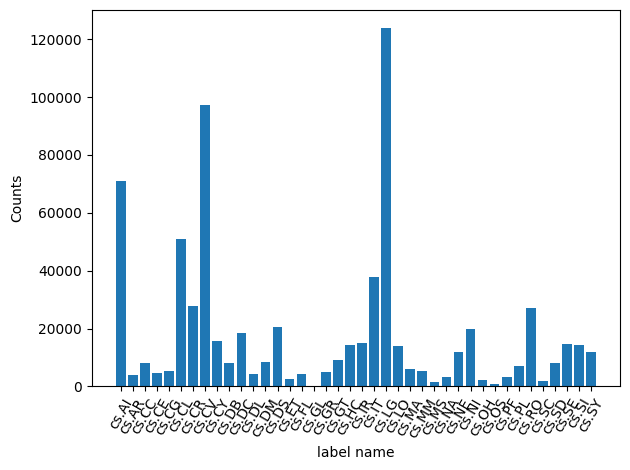

In [4]:
labels_counts = {}
multi_label_counts = {}
for labels in title_categories["categories"]:
    multi_label_counts[len(labels)] = multi_label_counts.get(len(labels), 0) + 1
    for label in labels:
        labels_counts[label] = labels_counts.get(label, 0) + 1

print(multi_label_counts)
label_set = sorted(labels_counts.keys())
# 40 类
plt.bar(label_set, [labels_counts[key] for key in label_set])
plt.xticks(rotation=60)
plt.xlabel("label name")
plt.ylabel("Counts")
plt.tight_layout()
plt.show()


## multi_label_counts：
- num_labels : counts
- 1 :  276364
- 2 :  136602
- 3 :  40881
- 4 :  7712
- 5 :  1174
- 6 :  28
- 7 :  3

绝大多数的paper的label个数在5个以内，大多数在3个以内。

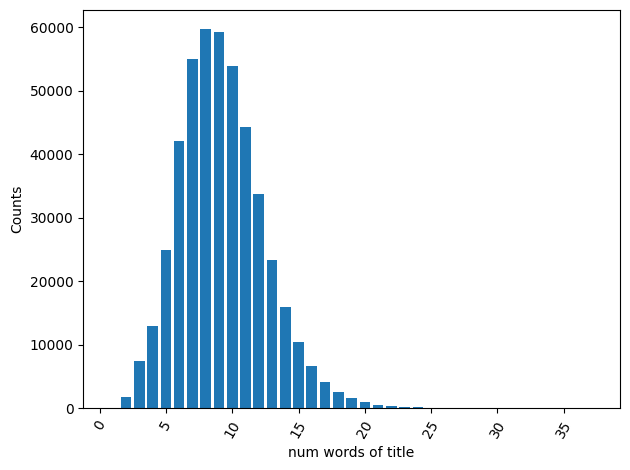

In [5]:
title_word_counts = {}
for title in title_categories["title"]:
    title_parsed = title.split()
    title_word_counts[len(title_parsed)] = title_word_counts.get(len(title_parsed), 0) + 1

#for key in sorted(title_word_counts.keys()):
#    print("num_words=", key, ": ", title_word_counts[key])
# max is 37
    
plt.bar(sorted(title_word_counts.keys()), [title_word_counts[key] for key in sorted(title_word_counts.keys())])
plt.xticks(rotation=60)
plt.xlabel("num words of title")
plt.ylabel("Counts")
plt.tight_layout()
plt.show()
    

In [48]:
# Load model directly
from transformers import BertModel,BertTokenizer
model_name = "google/bert_uncased_L-2_H-128_A-2"
bert_model = BertModel.from_pretrained(model_name)
tokenizer = BertTokenizer.from_pretrained(model_name)
tokenizer.vocab_size

30522

In [43]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
def make_train_val_data(title_categories:pd.DataFrame, val_radio, label_set, ):

    Binarizer = MultiLabelBinarizer(classes=label_set)
    # 将label列表转换成k-hot形式的multi-labels
    y_multilabels = Binarizer.fit_transform(title_categories["categories"].values)
    print(y_multilabels[0])
    out = tokenizer.batch_encode_plus(title_categories["title"].to_list(), max_length=20,
                                    padding="max_length", truncation=True)
   
    input_ids = np.array(out['input_ids'])
    attention_masks = np.array(out['attention_mask'])
    print(input_ids[0], attention_masks[0])
    x_train, x_val, mask_train, mask_val, y_train, y_val = train_test_split(input_ids, attention_masks, y_multilabels, test_size=val_radio, random_state=49)
    return (x_train, mask_train, y_train), (x_val, mask_val, y_val)


In [8]:
class MyDataSet(Dataset):
    def __init__(self, X, masks, y) -> None:
        super().__init__()
        self.X = torch.from_numpy(X).int()
        self.masks = torch.from_numpy(masks).int()
        self.y = torch.from_numpy(y).float()
    
    def __len__(self):
        return self.X.shape[0]
    
    def __getitem__(self, index):
        return self.X[index], self.masks[index], self.y[index]

## 多类分类

In [11]:
# 将categories列表中的第一项作为样本的class

title_classes = title_categories.copy()
title_classes["categories"] = title_categories["categories"].apply(lambda x: [x[0]])
title_classes.head()


,title,categories
46,Intelligent location of simultaneously active ...,[cs.NE]
49,Intelligent location of simultaneously active ...,[cs.NE]
61,On-line Viterbi Algorithm and Its Relationship...,[cs.DS]
89,Real Options for Project Schedules (ROPS),[cs.CE]
97,Sparsely-spread CDMA - a statistical mechanics...,[cs.IT]


In [44]:
# tokenize 耗时长
train1, val1 = make_train_val_data(title_classes, 0.2, label_set)

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0
 0 0 0]
[  101  9414  3295  1997  7453  3161  6490 15760  4216  1024  2112  1045
   102     0     0     0     0     0     0     0] [1 1 1 1 1 1 1 1 1 1 1 1 1 0 0 0 0 0 0 0]


In [45]:
batch_size = 128
train_dataset1, val_dataset1 = MyDataSet(*train1), MyDataSet(*val1)
train_loader1, val_loader1 = DataLoader(train_dataset1, batch_size, shuffle=True), DataLoader(val_dataset1, batch_size)
print(len(train_dataset1), len(val_dataset1))

370211 92553


In [46]:
class MyClassifier1(nn.Module):
    """文本多分类模型"""
    def __init__(self, num_hidden, num_class):
        super().__init__()
        self.bert = bert_model    # 作为embedding层，进行fine-tuning
        for param in self.bert.parameters():
            param.requires_grad = True
        
        self.fc1 = nn.Linear(256, num_hidden)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(num_hidden, num_class)
  
    def forward(self, x, mask):
        # 取bert最后一层隐状态
        out = self.bert(x, attention_mask=mask, token_type_ids=None,)
        # print(out.keys())
        # last_hidden_state = out["last_hidden_state"]  # N, 20, 128
        pooled = out["pooler_output"]
        #print(out.shape)
        #print(out.shape)
        out = self.act1(self.fc1(pooled))
        out = self.fc2(out)
        return out


In [47]:
from transformers import get_scheduler
from tqdm.auto import tqdm
# 定义模型，优化器，损失函数...
model1 = MyClassifier1(num_hidden=128 ,num_class=40)

optimizer1 = optim.AdamW(model1.parameters(), lr=5e-4) #fine-tuning bert
criterion1 = nn.CrossEntropyLoss()
num_epochs = 5
num_training_steps1 = num_epochs * len(train_loader1)

lr_scheduler1 = get_scheduler(
    name="linear", optimizer=optimizer1, num_warmup_steps=0, 
    num_training_steps=num_training_steps1)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model1.to(device)

### metric
def accuracy(y_pred, y_true):
    """
    y_pred: (batch_size, C)
    y_true: (batch_size, C)
    """
    batch_size = y_true.shape[0]
    y_pred, y_true = y_pred.to(device), y_true.to(device)
    pred_ids, true_ids = torch.argmax(y_pred, dim=1), torch.argmax(y_true, dim=1)
    acc = torch.sum(pred_ids == true_ids).item() / batch_size
    return acc

def eval1(net, val_loader, metric):
    net.eval()
    acc = 0.0
    with torch.no_grad():
        for x, mask, y in val_loader:
            x, mask = x.to(device), mask.to(device)
            outputs = net(x, mask)
            acc += metric(outputs, y)
    return acc / len(val_loader)

## train
progress_bar = tqdm(range(num_training_steps1))

log_num = 1

for epoch in range(num_epochs):
    model1.train()
    epoch_loss = 0.0
    for x, mask, y in train_loader1:
        optimizer1.zero_grad()
        outputs = model1(x.to(device), mask.to(device))
        loss = criterion1(outputs.to(device), y.to(device))
        
        loss.backward()
        epoch_loss += loss.item()
        optimizer1.step()
        lr_scheduler1.step()
        
        progress_bar.update(1)
    if (epoch + 1)% log_num == 0:
        print(f"[Train]: {epoch + 1}/{num_epochs}, Loss: {epoch_loss/len(train_loader1)}")
    
        precision = eval1(model1, val_loader=val_loader1, metric=accuracy)
        
        print(f"accuracy={precision*100:.4f}%")



  0%|          | 0/14465 [00:00<?, ?it/s]

[Train]: 1/5, Loss: 1.4483649679586792
accuracy=64.8584%


KeyboardInterrupt: 

## 多元标签分类

In [ ]:
one_label, two_label, three_label = [], [], []
for index, row in title_categories.iterrows():
    num_label = len(row["categories"])
    if num_label == 1:
        one_label.append(row)
    elif num_label == 2:
        two_label.append(row)
    elif num_label == 3:
        three_label.append(row)


one_label, two_label, three_label = pd.DataFrame(one_label), pd.DataFrame(two_label), pd.DataFrame(three_label)
print(one_label.head())
print(two_label.head())
print(three_label.head())
sample_size = 30720
sample1 = one_label.sample(sample_size, replace=False)
sample2 = two_label.sample(sample_size, replace=False)
sample3 = three_label.sample(sample_size, replace=False)

In [ ]:
val_radio = 0.2
one_train, one_val = make_train_val_data(sample1, val_radio, label_set)
two_train, two_val = make_train_val_data(sample2, val_radio, label_set)
three_train, three_val = make_train_val_data(sample3, val_radio, label_set)
# train data
x_train = np.concatenate((one_train[0], two_train[0], three_train[0]), axis=0)
mask_train = np.concatenate((one_train[1], two_train[1], three_train[1]), axis=0)
y_train = np.concatenate((one_train[2], two_train[2], three_train[2]), axis=0)
# val data
x_val = np.concatenate((one_val[0], two_val[0], three_val[0]), axis=0)
mask_val = np.concatenate((one_val[1], two_val[1], three_val[1]), axis=0)
y_val = np.concatenate((one_val[2], two_val[2], three_val[2]), axis=0)

In [ ]:
batch_size = 128
train_dataset, val_dataset = MyDataSet(x_train, mask_train, y_train), MyDataSet(x_val, mask_val, y_val)
train_loader, val_loader = DataLoader(train_dataset, batch_size, shuffle=True), DataLoader(val_dataset, batch_size*2, shuffle=True)
print(len(train_dataset), len(val_dataset))

In [ ]:
class MyClassifier(nn.Module):
    def __init__(self, num_hidden, num_class):
        super().__init__()
        self.bert = bert_model    # 作为embedding层，进行fine-tuning
        for param in self.bert.parameters():
            param.requires_grad = True
        
        # k cnn-filters k(out_channels)->32
        # 试了一下(16, 32, 48) 32的效果最好
        self.conv1 = nn.Conv2d(1, 48, kernel_size=(3, 128)) # out= in - kernel_size + 1
        self.conv2 = nn.Conv2d(1, 48, kernel_size=(5, 128))
        self.conv3 = nn.Conv2d(1, 48, kernel_size=(7, 128))
        # N,C_out,
        self.pooling = nn.MaxPool2d((3,1), (3,1))
        self.fc1 = nn.Linear(48*12, num_hidden)
        self.act1 = nn.ReLU()
        self.fc2 = nn.Linear(num_hidden, num_hidden)
        self.act2 = nn.ReLU()
        self.fc3 = nn.Linear(num_hidden, num_class)
  
    def forward(self, x, mask):
        # 取bert最后一层隐状态
        out = self.bert(x, attention_mask=mask, token_type_ids=None,)
        last_hidden_state = out["last_hidden_state"]  # N, 16, 128
        #print(hidden_states.shape)
        last_hidden_state.unsqueeze_(1)  # N, 1, 16, 128
        
        out1 = self.conv1(last_hidden_state)  # 16 - 3 + 1
        out2 = self.conv2(last_hidden_state)
        out3 = self.conv3(last_hidden_state)
        out = torch.cat([out1, out2, out3], dim=2)  # N, 32, (14 + 12 + 10 = 36), 1
        out = self.pooling(out)  # N, 32, 12, 1
        #print(out.shape)
        out = out.reshape(out.shape[0], -1)
        #print(out.shape)
        out = self.act1(self.fc1(out))
        out = self.act2(self.fc2(out))
        out = self.fc3(out)
        
        #print(out.shape)
        return out
        

In [ ]:
def adaptive_precision(predicts, labels):
    predicts, labels = predicts.to(device), labels.to(device)
    precision = 0.0
    for i in range(labels.shape[0]):
        labels_num, label_ids = torch.sum(labels[i]).item(), torch.nonzero(labels[i]).squeeze()
        # 根据实际label数，选择predict中预测topk
        _, pred_ids = predicts[i].topk(int(labels_num))
        # 计算两组下标相同元素的数目，从而获得precision，并累加
        precision += torch.sum(torch.isin(pred_ids, label_ids)).item() / labels_num
    return precision / labels.shape[0]

def precision_k(predicts, labels, k=3):
    """
    predicts : (batch_size, C)
    labels : (batch_size, C)  {0, 1}^C
    """
    predicts, labels = predicts.to(device), labels.to(device)
    _, topk_pred_ids = predicts.topk(k, dim=1)  # batch_size, k

    precision_rank_k = torch.zeros(labels.shape[0]).to(device) # batch_size,
    
    for pred_ids in topk_pred_ids.T:
        precision_rank_k += labels[torch.arange(labels.shape[0]), pred_ids]
        
    return precision_rank_k / k

def topk_eval(net, top_k:list, val_loader, metric=precision_k):
    net.eval()
    correct_topk = torch.zeros(len(top_k))
    with torch.no_grad():
        for x, mask, y in val_loader:
            x, mask = x.to(device), mask.to(device)
            outputs = net(x, mask)
            for i, k in enumerate(top_k):
                correct_topk[i] += metric(outputs, y, k).mean().item()
    
    return correct_topk / len(val_loader)

def actual_eval(net, val_loader, metric):
    net.eval()
    correct = 0.0
    with torch.no_grad():
        for x, mask, y in val_loader:
            x, mask = x.to(device), mask.to(device)
            outputs = net(x, mask)
            correct += metric(outputs, y)
                   
    return correct / len(val_loader)
    

In [ ]:
from transformers import get_scheduler
model = MyClassifier(num_hidden=256 ,num_class=40)
# optimizer = optim.Adam(model.parameters(), lr=1e-3)
optimizer = optim.AdamW(model.parameters(), lr=1e-4) #fine-tuning bert
criterion = nn.BCEWithLogitsLoss()
num_epochs = 5
num_training_steps = num_epochs * len(train_loader)

lr_scheduler = get_scheduler(
    name="linear", optimizer=optimizer, num_warmup_steps=0, 
    num_training_steps=num_training_steps)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model.to(device)

In [ ]:
from tqdm.auto import tqdm

progress_bar = tqdm(range(num_training_steps))

top_k = [1, 2, 3]
actual = True
log_num = 1
for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0.0
    for x, mask, y in train_loader:
        optimizer.zero_grad()
        outputs = model(x.to(device), mask.to(device))
        loss = criterion(outputs.to(device), y.to(device))
        #with torch.autograd.set_detect_anomaly(True):
        loss.backward()
        epoch_loss += loss.item()
        optimizer.step()
        lr_scheduler.step()
        
        progress_bar.update(1)
    if (epoch + 1)% log_num == 0:
        print(f"[Train]: {epoch + 1}/{num_epochs}, Loss: {epoch_loss/len(train_loader)}")
    
        precisions = topk_eval(model, top_k, val_loader=val_loader)
        for i, k in enumerate(top_k):    
            print(f"P@{k}={precisions[i].item()*100:.4f}%")
        if actual:   # 根据实际label数目计算的precision
            actual_precison = actual_eval(model, val_loader, metric=adaptive_precision)
            print(f"adapted_P={actual_precison*100:.4f}%")



In [ ]:
def predict_categories(model, titles:list[str], label_set=label_set, tokenizer=tokenizer):
    num_papers = len(titles)
    pred_categories = {}
    model.cpu()
    model.eval()
    out = tokenizer.batch_encode_plus(titles, max_length=16,
                                  padding="max_length", truncation=True)
    token_ids, attn_masks = out["input_ids"], out["attention_mask"]
    # 转为tensor，
    token_ids = torch.tensor(token_ids).int()
    attn_masks = torch.tensor(attn_masks).int()

    with torch.no_grad():
        for i in range(num_papers):
            # 添加batch_size维度
            x, mask = token_ids[i].unsqueeze_(0), attn_masks[i].unsqueeze_(0)
            output = model(x, mask)
            # 获取top3的标签
            _, pred_ids = output.topk(k=3)
            
            pred_categories[titles[i]] = [label_set[ids.item()] for ids in pred_ids.squeeze(0)]

    return pred_categories

In [ ]:
with open("/kaggle/input/mydatasets/test_t_c.json") as f:
    test_t_c = json.load(f)
    
test_t_c = pd.DataFrame([[k, v] for k, v in test_t_c.items()], columns=["title", "categories"])
    
for index, row in test_t_c.iterrows():
    words = row["categories"]
    processed_words = [word for word in words if word.startswith('cs.')]
    
    test_t_c.at[index, "categories"] = processed_words
test_t_c[50:60]

In [ ]:
test_titles = test_t_c["title"].to_list()[20:30]
# test_titles = ["LayerCollapse: Adaptive compression of neural networks"]
pred_categories = predict_categories(model, titles=test_titles, label_set=label_set, tokenizer=tokenizer)
for k, v in pred_categories.items():
    print(k, ": ", v)